In [ ]:
######## ESTRUTURA DO CÓDIGO
# 1. DOWNLOAD DA BASE DE DADOS 
# 2. Preprocessamiento 
#    - Estatística descritiva
#    - Tratamiento de variáveis
#    - Preparacao base de dados para modelos e null inputation
# 3. Reducao de dimensionalidade ou feature extraction (selecao de variaveis)
# 4. Modelos:
#    - Validacao modelo atual
#    - Construcao de modelo novo - Técnicas, medicao, TH
#     - Com modelo atual
#     - Sem modelo atual
#    - Revisao necesidade de criar mais variaveis
# 5. Conclusao 

In [71]:
#### Acá importo todas las librerías que vaya a usar 
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pr
import numpy as np
import seaborn as sns
import re
import unicodedata
import time

%matplotlib inline
from matplotlib.gridspec import GridSpec
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
#### FUNCIONES PARA CREAR PIPELINE DE MODELOS 
def PCA_var(varianza,X):
    """
    Function responsible for calculating the number of components to explain the % of variance 
    
    Returns:
        number of components
    """
 
   
    pca = PCA(varianza)
    pca_fit = pca.fit(X)
    features = pca_fit.n_components_
    
    return features
    
    
def PCA_comp(comp,X):
    """
    Function responsible for calculating the explained variance based on a number of components
    
    Returns:
        Explained variance
    """
    
    pca = PCA(n_components=comp)
    pca_fit = pca.fit(X)
    var = np.sum(pca_fit.explained_variance_ratio_)
    
    return var
    




def create_dataset():
    """
    Function responsible for creating an empty DataFrame object with some of classification metrics
    
    Returns:
        empty DataFrame object
    """
    attributes = ['acc', 'prec', 'rec', 'f1', 'total_time']
    model_performance = pd.DataFrame({})
    for col in attributes:
        model_performance[col] = []
        
    return model_performance

def model_analysis(model, X, y, X_test, y_test, df_performance, cv=5, train=True):
    """
    Function responsible for evaluate a classification model and save the results on a DataFrame object
    
    Input:
        model: model to be used on evaluation
        X, y, X_test, y_test: train and test data (with target labels)
        df_performance: empty DataFrame (generated by create_dataset() function)
        cv: cross validation k folds

    Returns:
        a DataFrame object with classification metrics selected
    """
    # Accuracy, precision, recall and f1_score on training set using cv
    t0_cv = time.time()
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    prec = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    rec = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    # Time spent on cross_validation prediction
    t1_cv = time.time()
    delta_time_cv = t1_cv-t0_cv
    
    # Evaluation using the test set
    t0_test = time.time()
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    y_scores_test = model.predict_proba(X_test)[:, 1]
    # Time spent on test prediction
    t1_test = time.time()
    delta_time_test = t1_test-t0_test

    # Saving on dataframe
    performances = {}
    performances['acc'] = round(acc, 4)
    performances['prec'] = round(prec, 4)
    performances['rec'] = round(rec, 4)
    performances['f1'] = round(f1, 4)
    performances['total_time'] = round(delta_time_cv, 3)        
    df_performance = df_performance.append(performances, ignore_index=True)
    
    test_performances = {}
    test_performances['acc'] = round(acc_test, 4)
    test_performances['prec'] = round(prec_test, 4)
    test_performances['rec'] = round(rec_test, 4)
    test_performances['f1'] = round(f1_test, 4)
    test_performances['total_time'] = round(delta_time_test, 3)        
    df_performance = df_performance.append(test_performances, ignore_index=True)
    
    model_name = model.__class__.__name__
    df_performance.index = [model_name+' cv', model_name+' test']
    
    return df_performance

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots a customized confusion matrix
    
    Input:
        cm: confusion matrix generated from sklearn's method confusion_matrix(set, predictions)
        classes: target labels to be plotted
        title: title
        cmap: matrix color
    Output:
        None
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Plot configuration
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def style_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'grey',
        'weight': 1.5,
        'dashArray': '5, 5'
    }


In [ ]:
# 1. DOWNLOAD DA BASE DE DADOS 
#### DOWNLOAD DAS BASES DE DADOS

url = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/rain_data_aus.csv'

w1 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_01.csv'
w2 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_02.csv'
w3 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_03.csv'
w4 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_04.csv'
w5 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_05.csv'
w6 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_06.csv'
w7 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_07.csv'
w8 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_08.csv'
                    

data = pd.read_csv(url,sep=",") 
data_w1 = pd.read_csv(w1,sep=",")
data_w2 = pd.read_csv(w2,sep=",")
data_w3 = pd.read_csv(w3,sep=",") 
data_w4 = pd.read_csv(w4,sep=",") 
data_w5 = pd.read_csv(w5,sep=",") 
data_w6 = pd.read_csv(w6,sep=",") 
data_w7 = pd.read_csv(w7,sep=",") 
data_w8 = pd.read_csv(w8,sep=",") 

In [6]:
#### TIPOS DE DADOS
#data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
date                142193 non-null object
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            140787 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           140787 non-null object
amountOfRain        142193 non-null float64
raintomorrow        142193 non-null object
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm 

In [8]:
# 2. Preprocessamiento
#### REEMPLAZO LA VARIAVEL RESPOSTA

data['raintoday']=data['raintoday'].replace({'No': 0, 'Yes': 1})
data['raintomorrow']=data['raintomorrow'].replace({'No': 0, 'Yes': 1})

In [7]:
#### REVISO OS NOMES DAS COLUNAS

print('data_w1:'+f'{list(data_w1)}\n')
print('data_w2:'+f'{list(data_w2)}\n')
print('data_w3:'+f'{list(data_w3)}\n')
print('data_w4:'+f'{list(data_w4)}\n')
print('data_w5:'+f'{list(data_w5)}\n')
print('data_w6:'+f'{list(data_w6)}\n')
print('data_w7:'+f'{list(data_w7)}\n')
print('data_w8:'+f'{list(data_w8)}\n')

data_w1:['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']

data_w2:['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']

data_w3:['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']

data_w4:['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']

data_w5:['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']

data_w6:['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']

data_w7:['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']

data_w8:['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']



In [9]:
#### TRATO OS NOMES DAS COLUNAS

cols=['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']
data_w1.columns = cols
data_w2.columns = cols

In [10]:
#### CRIO UN DATA SET COM AS INFORMACOES ADICIONAIS

frames = [data_w1,data_w2,data_w3,data_w4,data_w5,data_w6,data_w7,data_w8]
data_w = pd.concat(frames, sort=False)

In [11]:
#### JOINING THE DATASETS
db_model = data.merge(data_w, on=['date','location'], how='left')
#db_model.head()

In [15]:
#### RODO A PRIMEIRA ESTADÍSTICA DESCRIPTIVA DA BASE DE DADOS
# Nao tomo decisoes ainda sobre as variaveis correlacionadas porque nao sei qual discrimina mais
pr.ProfileReport(db_model)

Number of variables,29
Number of observations,164386
Total Missing (%),7.6%
Total size in memory,37.6 MiB
Average record size in memory,240.0 B
Numeric,19
Categorical,5
Boolean,1
Date,0
Text (Unique),0
Rejected,4


In [16]:
#### RODO A MEDIA DA CHUVA PARA VER SE TEM TENDENCIAS E ESTACIONARIEDADE FORTE

mean_rain=db_model.groupby('date',as_index=False).mean()
#mean_rain.head()

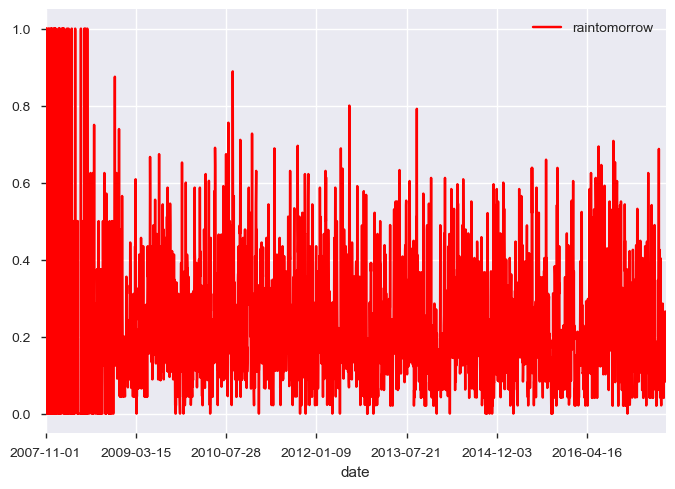

In [17]:
#%matplotlib notebook
mean_rain.plot(kind='line',x='date',y='raintomorrow',color='red')
plt.show()

In [18]:
#### CRIACAO DE VARIAVEIS DE TEMPO

db_model['month']=db_model['date'].str.slice(start=5, stop=7)
db_model['month_day']=db_model['date'].str.slice(start=5, stop=10)

In [19]:
#### DIVISAO DAS VARIAVEIS EXPLICATIVAS E DE PERFORMANCE

X=db_model.drop(['raintomorrow','date'],axis=1)
y = db_model['raintomorrow'].values
Y_tf = y.astype(int)

In [20]:
#### VALIDACAO DAS VARIAVEIS CATEGORICAS PARA VER COMO TRATAR OS NULLS
# Reviso si hay valores nulos en las variables categoricas

categorical=[var for var in X.columns if X[var].dtype=='object']
X[categorical].isnull().sum()

location           0
windgustdir    10578
winddir9am     11428
winddir3pm      4835
month              0
month_day          0
dtype: int64

In [21]:
#### CRIACAO DE VARIAVEIS DUMMY
# Se crean variables dummy de las categoricas para facilidad de uso en los modelos posteriormente
# Se obtiene un conjunto con muchas variables - posibles problemas de scarcity
X_d=pd.get_dummies(X)
X_d.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,...,month_day_12-22,month_day_12-23,month_day_12-24,month_day_12-25,month_day_12-26,month_day_12-27,month_day_12-28,month_day_12-29,month_day_12-30,month_day_12-31
0,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,...,0,0,0,0,0,0,0,0,0,0
1,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,...,0,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,...,0,0,0,0,0,0,0,0,0,0
3,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#### ELIMINACAO DE VARIAVEIS PARA EVITAR COLINEARIDADE
#Se elimina una de las dummies de cada variable que tenia 0 missings
# Para las otras no es necesario porque está la categría de missing
X_d=X_d.drop(['location_Woomera','month_12','month_day_12-31'],axis=1)
cols = list(X_d.columns)

In [50]:
#### NULL INPUTATION
# Arreglo los valores null con la mediana porque es más robusta que la media frente a valores extremos.
X_d = X_d.fillna(X_d.median())

X_train, X_test, y_train, y_test = train_test_split(X_d, Y_tf, test_size = 3/10, random_state = 9)

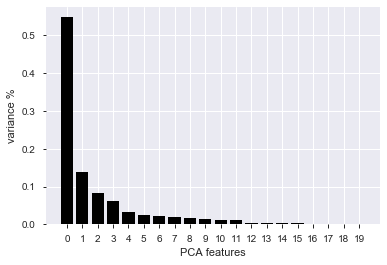

In [51]:
# 3. Reducao de dimensionalidade ou feature extraction (selecao de variaveis)
######## DIM. REDUCTION - PCA
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(X_train)
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_train)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [53]:
# Ao ter tao pouca varianza explicada com 20 componentes se analiza se continuar usando: 
# Sao necessarios muitos componentes para explicar el 95% de la varianza 

var=0.95
comp=15
print('Precisa de: '+f'{PCA_var(var,X_std)}'+' para obter '+f'{var*100}'+'% de varianza')
print('Obteria: '+f'{PCA_comp(comp,X_std)*100}'+'% de varianza explicada com '+f'{comp}'+' componentes')


Precisa de: 435 para obter 95.0% de varianza
Obteria: 8.251064388108109% de varianza explicada com 15 componentes


In [54]:
######## AQUI COMIENZA LA PARTE DE FEATURE EXTRACTION 
# Parametros RF
clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)

In [55]:
# Treino RF 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [56]:
# Faco as predicoes
y_pred = clf.predict(X_test)

In [57]:
score = clf.score(X_test, y_test)
print(score)

0.8930975748235866


In [58]:
# Evaluo os resultados
empty_train_performance = create_dataset()
rf_performance = model_analysis(clf, X_train, y_train, X_test, y_test,empty_train_performance)
rf_performance

,acc,prec,rec,f1,total_time
RandomForestClassifier cv,0.9013,0.9965,0.5661,0.7218,762.324
RandomForestClassifier test,0.8931,0.9897,0.5261,0.6870,5.394


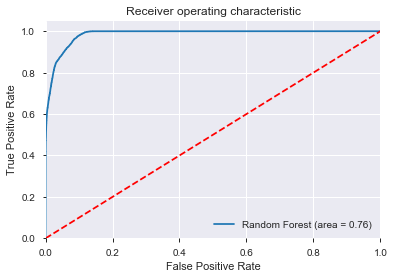

In [59]:
# Crio curva ROC para ver a performance do primeiro modelo e seleciono variaveis
rf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [60]:
X_test

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,...,month_day_12-21,month_day_12-22,month_day_12-23,month_day_12-24,month_day_12-25,month_day_12-26,month_day_12-27,month_day_12-28,month_day_12-29,month_day_12-30
6705,12.4,24.7,0.0,4.8,8.4,82.0,57.0,1030.5,1027.0,5.0,...,0,0,0,0,0,0,0,0,0,0
77894,11.2,14.4,2.8,2.6,0.0,89.0,80.0,1010.8,1009.3,7.0,...,0,0,0,0,0,0,0,0,0,0
126365,9.5,17.8,0.4,4.8,8.4,75.0,57.0,1019.7,1018.4,5.0,...,0,0,0,0,0,0,0,0,0,0
133554,7.0,15.5,8.0,2.6,4.0,95.0,61.0,1017.4,1016.1,7.0,...,0,0,0,0,0,0,0,0,0,0
146871,9.4,14.6,0.2,2.4,3.1,74.0,38.0,1008.8,1008.3,7.0,...,0,0,0,0,0,0,0,0,0,0
30474,9.6,20.0,0.2,4.8,8.4,70.0,52.0,1017.6,1015.2,5.0,...,0,0,0,0,0,0,0,0,0,0
77781,8.9,14.5,1.4,1.6,6.1,81.0,70.0,1001.9,1000.7,3.0,...,0,0,0,0,0,0,0,0,0,0
7966,13.0,25.4,0.0,6.6,8.4,65.0,38.0,1014.4,1011.8,0.0,...,0,0,0,0,0,0,0,0,0,0
63174,9.6,16.1,0.0,4.8,8.4,83.0,79.0,1008.2,1012.5,8.0,...,0,0,0,0,0,0,0,0,0,0
140983,5.5,18.9,0.2,4.8,8.4,95.0,54.0,1017.6,1015.2,5.0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
#Validacao do modelo atual
Y_mv=X_test['modelo_vigente']

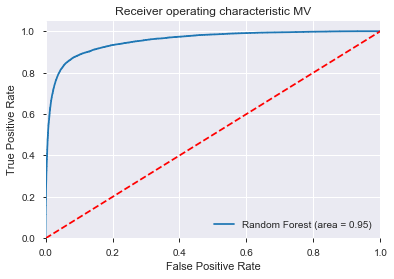

In [62]:
# ROC do modelo atual

rf_roc_auc_mv = roc_auc_score(y_test, Y_mv)
fpr, tpr, thresholds = roc_curve(y_test, Y_mv)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc_mv)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic MV')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [63]:
#Faco selecao de variaveis
feature_imp = pd.Series(clf.feature_importances_,index=cols).sort_values(ascending=False)
#feature_imp

No handles with labels found to put in legend.


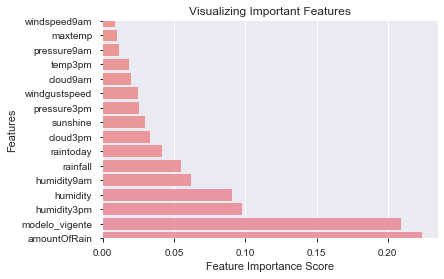

In [64]:
# Ordeno as variaveis com base na importancia do modelo
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# control x and y limits
plt.ylim(0, 15)
plt.xlim(0, None)


# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [65]:
# Pego as primeiras 20 variaveis explicativas 
vars_usar=feature_imp.index[0:20]
vars_usar

Index(['amountOfRain', 'modelo_vigente', 'humidity3pm', 'humidity',
       'humidity9am', 'rainfall', 'raintoday', 'cloud3pm', 'sunshine',
       'pressure3pm', 'windgustspeed', 'cloud9am', 'temp3pm', 'pressure9am',
       'maxtemp', 'windspeed9am', 'temp', 'temp9am', 'mintemp', 'evaporation'],
      dtype='object')

In [66]:
# Faco um subset com as variaveis novas
X_new=X_d[vars_usar]


In [67]:
# Faco uma analise descriptivo e de correlacao das variaveis escolidas
pr.ProfileReport(X_new)

Number of variables,20
Number of observations,164386
Total Missing (%),0.0%
Total size in memory,26.3 MiB
Average record size in memory,168.0 B
Numeric,16
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,3


In [68]:
# Elimino as variaveis que tem correlacao 
X_train=X_train[vars_usar]
X_train=X_train.drop(['humidity','pressure9am', 'temp3pm'],axis=1)

X_test=X_test[vars_usar]
X_test=X_test.drop(['humidity','pressure9am', 'temp3pm'],axis=1)

In [69]:
# Reviso o tamanho do meu set
X_train.shape

(115070, 17)

In [72]:
# Aplico GBC no meu conjunto de train e test
gbrt=GradientBoostingClassifier(random_state=9)
gbrt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=9, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [73]:
# Evaluating results
empty_train_performance = create_dataset()
gbc_performance = model_analysis(gbrt, X_train, y_train, X_test, y_test,empty_train_performance)
gbc_performance

,acc,prec,rec,f1,total_time
GradientBoostingClassifier cv,1.0,1.0,1.0,1.0,291.526
GradientBoostingClassifier test,1.0,1.0,1.0,1.0,0.588


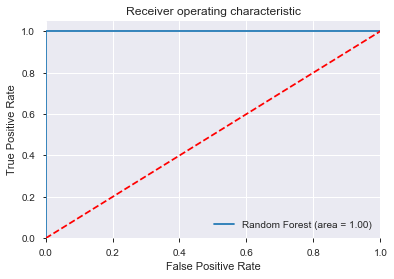

In [74]:
# Calculo curva ROC
gbc_roc_auc = roc_auc_score(y_test, gbrt.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbrt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % gbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [75]:
# Reg. logistica para validar frente aos modelos mais complexos e com menor explicacao

# Training a Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
score = logreg_model.score(X_test, y_test)
print(score)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9998377808419174


In [76]:
# Evaluating results
empty_train_performance = create_dataset()
log_reg_performance = model_analysis(logreg_model, X_train, y_train, X_test, y_test,empty_train_performance)
log_reg_performance

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

,acc,prec,rec,f1,total_time
LogisticRegression cv,0.9997,0.9997,0.9989,0.9993,95.415
LogisticRegression test,0.9998,0.9997,0.9995,0.9996,0.220


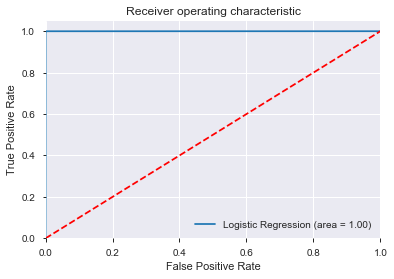

In [77]:
#Calculo ROC de la regresion logistica
logit_roc_auc = roc_auc_score(y_test, logreg_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [78]:
# RF
clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
empty_train_performance = create_dataset()
rf_performance = model_analysis(clf, X_train, y_train, X_test, y_test,empty_train_performance)
rf_performance

,acc,prec,rec,f1,total_time
RandomForestClassifier cv,1.0,1.0,1.0,1.0,422.854
RandomForestClassifier test,1.0,1.0,1.0,1.0,3.987


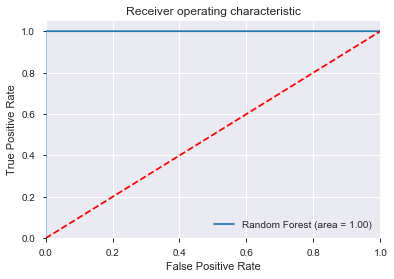

In [79]:
# Crio curva ROC o modelo de RF
rf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [80]:
# logit
logit_roc_auc

0.9997335594948341

In [81]:
# XGB
gbc_roc_auc

1.0

In [82]:
# RF
rf_roc_auc

1.0

In [ ]:
# Conclusao
# Ao ter performance quase igual dos modelos é possivel implementar uma regressao logistica para predicer o clima
# Proximo paso é testar uma metodologia so com selecao de variaveis excluido o modelo atual para ver se é possivel
# ter um resultado similiar 